# Getting started with TensorRT-LLM

In this notebook we are optimizing Bloom 560M for inference using TensorRT-LLM. <br>
We compare inference speed results from the **baseline** model (Huggingface), the **optimized** model, <br>
and the optimized model after **INT8-quantization**.

***Source:***
https://github.com/NVIDIA/TensorRT-LLM/tree/main/examples/bloom

### Installing the NVIDIA Container Toolkit

In [1]:
!pwd

/workspace


In [25]:
!curl -fsSL https://nvidia.github.io/libnvidia-container/gpgkey |  gpg --dearmor -o /usr/share/keyrings/nvidia-container-toolkit-keyring.gpg \
  && curl -s -L https://nvidia.github.io/libnvidia-container/stable/deb/nvidia-container-toolkit.list | \
    sed 's#deb https://#deb [signed-by=/usr/share/keyrings/nvidia-container-toolkit-keyring.gpg] https://#g' | \
     tee /etc/apt/sources.list.d/nvidia-container-toolkit.list

!apt-get update

File '/usr/share/keyrings/nvidia-container-toolkit-keyring.gpg' exists. Overwrite? (y/N) 
gpg: signal 2 caught ... exiting
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://nvidia.github.io/libnvidia-container/stable/deb/amd64  InRelease [1477 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1244 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2844 kB]
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Fetched 4218 kB in 1s (3260 kB/s)
Reading package lists... Done


### Installing TensorRT-LLM

In [26]:
!git clone --branch "v0.17.0" https://github.com/NVIDIA/TensorRT-LLM/

Cloning into 'TensorRT-LLM'...
remote: Enumerating objects: 58011, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 58011 (delta 134), reused 86 (delta 86), pack-reused 57815 (from 3)
Receiving objects: 100% (58011/58011), 1.10 GiB | 18.02 MiB/s, done.
Resolving deltas: 100% (44085/44085), done.
Note: switching to '258c7540c03517def55d9a5aadfa9288af474e1b'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

Updating files: 100% (4515/4515), done.
Filtering con

In [1]:
!apt-get update && apt-get -y install python3.10 python3-pip openmpi-bin libopenmpi-dev
!pip3 install tensorrt-llm==0.17.0.post1 --pre --extra-index-url https://pypi.nvidia.com

Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [34.3 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [164 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1792 kB]    
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4272 kB]
G

### Downloading BLOOM

BLOOM is an autoregressive Large Language Model (LLM), trained to continue text from a prompt on vast amounts of text data using industrial-scale computational resources. As such, it is able to output coherent text in 46 languages and 13 programming languages that is hardly distinguishable from text written by humans. BLOOM can also be instructed to perform text tasks it hasn't been explicitly trained for, by casting them as text generation tasks.

In [ ]:
!pip install -r TensorRT-LLM/examples/bloom/requirements.txt

In [3]:
!apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 131 not upgraded.
Need to get 3544 kB of archives.
After this operation, 10.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 git-lfs amd64 3.0.2-1ubuntu0.3 [3544 kB]
Fetched 3544 kB in 1s (6614 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package git-lfs.
(Reading database ... 25341 files and directories currently installed.)
Preparing to unpack .../git-lfs_3.0.2-1ubuntu0.3_amd64.deb ...
Unpacking git-lfs (3.0.2-1ubuntu0.3) ...
Setting up git-lfs (3.0.2-1ubuntu0.3) ...
Git LFS initialized.


In [ ]:
BLOOM_PATH="TensorRT-LLM/examples/bloom"

!rm -rf TensorRT-LLM/examples/bloom/560M
!mkdir -p TensorRT-LLM/examples/bloom/560M && git lfs clone https://huggingface.co/bigscience/bloom-560m TensorRT-LLM/examples/bloom/560M

### Converting and Building

In [135]:
# Convert checkpoint from HF to TRT-LLM format
!python3 TensorRT-LLM/examples/bloom/convert_checkpoint.py --model_dir TensorRT-LLM/examples/bloom/560M/ \
                --dtype float16 \
                --output_dir TensorRT-LLM/examples/bloom/560M/trt_ckpt/fp16/1-gpu/

[TensorRT-LLM] TensorRT-LLM version: 0.9.0.dev2024030500
0.9.0.dev2024030500
[03/06/2024-20:31:52] [TRT-LLM] [I] Convert by using checkpoint
[03/06/2024-20:31:52] [TRT-LLM] [I] Loading weights from HF BLOOM...
Rank [0] Loading weights: 100%|███████████████████| 1/1 [00:05<00:00,  5.40s/it]
[03/06/2024-20:31:58] [TRT-LLM] [I] Weights loaded. Total time: 00:00:05
Total time of converting checkpoints: 00:00:26


In [ ]:
# Build TensorRT-LLM model from checkpoint
!trtllm-build --checkpoint_dir TensorRT-LLM/examples/bloom/560M/trt_ckpt/fp16/1-gpu/ \
                --gemm_plugin float16 \
                --output_dir TensorRT-LLM/examples/bloom/560M/trt_engines/fp16/1-gpu/

In [ ]:
# Build the BLOOM 560M using a single GPU and apply INT8 weight-only quantization.
!python3 TensorRT-LLM/examples/bloom/convert_checkpoint.py --model_dir TensorRT-LLM/examples/bloom/560M \
                --dtype float16 \
                --use_weight_only \
                --output_dir TensorRT-LLM/examples/bloom/560M/trt_ckpt/int8_weight_only/1-gpu/

!trtllm-build --checkpoint_dir TensorRT-LLM/examples/bloom/560M/trt_ckpt/int8_weight_only/1-gpu/ \
                --gemm_plugin float16 \
                --output_dir TensorRT-LLM/examples/bloom/560M/trt_engines/int8_weight_only/1-gpu/

# Benchmarking

Comparing execution time and **ROUGE** metrics on a **Summarization Task**.

**ROUGE** stands for **Recall-Oriented Understudy for Gisting Evaluation**.<br />
It is a set of metrics used to evaluate the quality of summaries by comparing them to one or more reference summaries.<br />

Since we are using NVIDIA's Python scripts for benchmarking, we need to capture **STDOUT** and parse the results from there.

In [138]:
%%capture bloom_hf_results
# Huggingface
!time python3 TensorRT-LLM/examples/bloom/../summarize.py --test_hf \
                       --hf_model_dir TensorRT-LLM/examples/bloom/560M/ \
                       --data_type fp16 \
                       --engine_dir TensorRT-LLM/examples/bloom/560M/trt_engines/fp16/1-gpu/

In [139]:
%%capture bloom_trt_results
# TensorRT-LLM
!time python3 TensorRT-LLM/examples/bloom/../summarize.py --test_trt_llm \
                       --hf_model_dir TensorRT-LLM/examples/bloom/560M/ \
                       --data_type fp16 \
                       --engine_dir TensorRT-LLM/examples/bloom/560M/trt_engines/fp16/1-gpu/

In [140]:
%%capture bloom_int8_results
# TensorRT-LLM (INT8)
!time python3 TensorRT-LLM/examples/bloom/../summarize.py --test_trt_llm \
                       --hf_model_dir TensorRT-LLM/examples/bloom/560M/ \
                       --data_type fp16 \
                       --engine_dir TensorRT-LLM/examples/bloom/560M/trt_engines/int8_weight_only/1-gpu/

In [ ]:
# Example output captured
print(bloom_int8_results())

# Visualizing the results

#### Parse results from STDOUT

In [142]:
import re

def parse_output(output):
    # Extracting execution time
    time_match = re.search(r'real\s+(\d+)m([\d.]+)s', output.stdout)
    if time_match:
        minutes = int(time_match.group(1))
        seconds = float(time_match.group(2))
        exec_time = minutes * 60 + seconds
    else:
        exec_time = None
    
    rouge_scores = re.findall(r'rouge[12Lsum]+ : ([\d.]+)', output.stdout)
    rouge_scores = [float(score) for score in rouge_scores] if rouge_scores else []
    
    latency_match = re.search(r'total latency: ([\d.]+) sec', output.stdout)
    latency = float(latency_match.group(1)) if latency_match else None
    
    tokens_match = re.search(r'total output tokens: (\d+)', output.stdout)
    total_tokens = int(tokens_match.group(1)) if tokens_match else None
    
    tokens_per_sec_match = re.search(r'tokens per second: ([\d.]+)', output.stdout)
    tokens_per_sec = float(tokens_per_sec_match.group(1)) if tokens_per_sec_match else None
    
    return exec_time, rouge_scores, latency, total_tokens, tokens_per_sec

In [143]:
# For bloom_hf_results
bloom_hf_exec_time, bloom_hf_rouge, _, _, _ = parse_output(bloom_hf_results)

# Only TensorRT-LLM optimized models have Tokens/s, latency, and total tokens
bloom_trt_exec_time, bloom_trt_rouge, bloom_trt_latency, bloom_trt_tokens, bloom_trt_tokens_per_sec = parse_output(bloom_trt_results)
bloom_int8_exec_time, bloom_int8_rouge, bloom_int8_latency, bloom_int8_tokens, bloom_int8_tokens_per_sec = parse_output(bloom_int8_results)

Text(0.5, 0, 'Model')

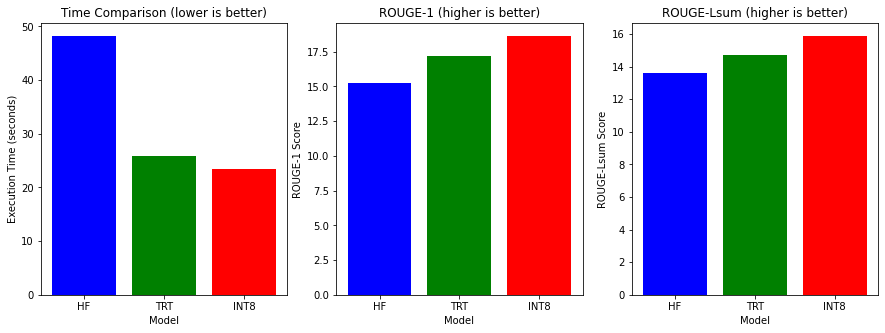

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt

# Execution times and Rouge Scores
exec_times = [bloom_hf_exec_time, bloom_trt_exec_time, bloom_int8_exec_time]
models = ['HF', 'TRT', 'INT8']

plt.figure(figsize=(15, 5))

# Plotting execution times
plt.subplot(1, 3, 1)
plt.bar(models, exec_times, color=['blue', 'green', 'red'])
plt.title('Time Comparison (lower is better)')
plt.ylabel('Execution Time (seconds)')
plt.xlabel('Model')

# Plotting ROUGE-1 scores
rouge1_scores = [bloom_hf_rouge[0], bloom_trt_rouge[0], bloom_int8_rouge[0]]
plt.subplot(1, 3, 2)
plt.bar(models, rouge1_scores, color=['blue', 'green', 'red'])
plt.title('ROUGE-1 (higher is better)')
plt.ylabel('ROUGE-1 Score')
plt.xlabel('Model')

# Plotting ROUGE-Lsum scores
rouge_lsum_scores = [bloom_hf_rouge[3], bloom_trt_rouge[3], bloom_int8_rouge[3]]
plt.subplot(1, 3, 3)
plt.bar(models, rouge_lsum_scores, color=['blue', 'green', 'red'])
plt.title('ROUGE-Lsum (higher is better)')
plt.ylabel('ROUGE-Lsum Score')
plt.xlabel('Model')

Text(0.5, 0, 'Model')

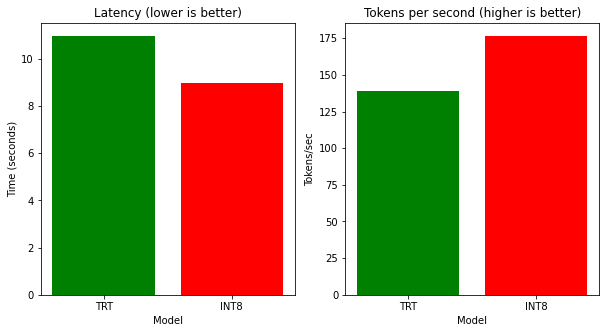

In [145]:
# Latency and Tokens per Sec
latencies = [bloom_trt_latency, bloom_int8_latency]
tps = [bloom_trt_tokens_per_sec, bloom_int8_tokens_per_sec]
models = ['TRT', 'INT8']

plt.figure(figsize=(10, 5))

# Plotting latency times
plt.subplot(1, 2, 1)
plt.bar(models, latencies, color=['green', 'red'])
plt.title('Latency (lower is better)')
plt.ylabel('Time (seconds)')
plt.xlabel('Model')

# Plotting tokens per seconds
rouge1_scores = tps
plt.subplot(1, 2, 2)
plt.bar(models, rouge1_scores, color=['green', 'red'])
plt.title('Tokens per second (higher is better)')
plt.ylabel('Tokens/sec')
plt.xlabel('Model')

# Launch Qwen2.5 1.5B model

In [4]:
!mkdir -p TensorRT-LLM/examples/qwen/7B && git lfs clone https://huggingface.co/Qwen/Qwen2.5-7B-Instruct TensorRT-LLM/examples/qwen/7B

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'TensorRT-LLM/examples/qwen/7B'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 50 (delta 21), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (50/50), 3.61 MiB | 2.10 MiB/s, done.


In [5]:
# Convert checkpoint from HF to TRT-LLM format
!python3 TensorRT-LLM/examples/qwen/convert_checkpoint.py --model_dir TensorRT-LLM/examples/qwen/7B/ \
                --dtype float16 \
                --output_dir TensorRT-LLM/examples/qwen/7B/trt_ckpt/fp16/1-gpu/

[TensorRT-LLM] TensorRT-LLM version: 0.17.0.post1
0.17.0.post1
230it [00:27,  8.23it/s]
Total time of converting checkpoints: 00:01:18


In [11]:
# Build TensorRT-LLM model from checkpoint
!trtllm-build --checkpoint_dir TensorRT-LLM/examples/qwen/7B/trt_ckpt/fp16/1-gpu/ \
                --max_seq_len 4096 \
                --max_num_tokens 4096 \
                --max_batch_size 1 \
                --gemm_plugin float16 \
                --output_dir TensorRT-LLM/examples/qwen/7B/trt_engines/fp16/1-gpu/

[TensorRT-LLM] TensorRT-LLM version: 0.17.0.post1
[04/24/2025-15:31:58] [TRT-LLM] [I] Set bert_attention_plugin to auto.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set gpt_attention_plugin to auto.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set gemm_plugin to float16.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set gemm_swiglu_plugin to None.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set fp8_rowwise_gemm_plugin to None.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set nccl_plugin to auto.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set lora_plugin to None.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set moe_plugin to auto.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set mamba_conv1d_plugin to auto.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set low_latency_gemm_plugin to None.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set low_latency_gemm_swiglu_plugin to None.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set context_fmha to True.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set bert_context_fmha_fp32_acc to False.
[04/24/2025-15:31:58] [TRT-LLM] [I] Set remove_input_padding 

In [7]:
!python3 TensorRT-LLM/examples/run.py --engine_dir TensorRT-LLM/examples/qwen/7B/trt_engines/fp16/1-gpu/  --max_output_len 100 --tokenizer_dir TensorRT-LLM/examples/qwen/7B/ --input_text "How do I count to nine in French?"

[TensorRT-LLM] TensorRT-LLM version: 0.17.0.post1
[TensorRT-LLM][INFO] Engine version 0.17.0.post1 found in the config file, assuming engine(s) built by new builder API.
[04/24/2025-15:24:30] [TRT-LLM] [I] Using C++ session
[TensorRT-LLM][INFO] Engine version 0.17.0.post1 found in the config file, assuming engine(s) built by new builder API.
[TensorRT-LLM][INFO] MPI size: 1, MPI local size: 1, rank: 0
[04/24/2025-15:24:30] [TRT-LLM] [W] Implicitly setting QWenConfig.seq_length = 8192
[04/24/2025-15:24:30] [TRT-LLM] [W] Implicitly setting QWenConfig.qwen_type = qwen2
[04/24/2025-15:24:30] [TRT-LLM] [W] Implicitly setting QWenConfig.moe_intermediate_size = 0
[04/24/2025-15:24:30] [TRT-LLM] [W] Implicitly setting QWenConfig.moe_shared_expert_intermediate_size = 0
[04/24/2025-15:24:30] [TRT-LLM] [W] Implicitly setting QWenConfig.tie_word_embeddings = False
[04/24/2025-15:24:30] [TRT-LLM] [I] Set dtype to float16.
[04/24/2025-15:24:30] [TRT-LLM] [I] Set bert_attention_plugin to auto.
[04/24

In [12]:
%%time
# Same
!python3 TensorRT-LLM/examples/run.py \
    --engine_dir "TensorRT-LLM/examples/qwen/7B/trt_engines/fp16/1-gpu/" \
    --max_output_len 2048 \
    --tokenizer_dir "TensorRT-LLM/examples/qwen/7B/" \
    --input_text "Write a detailed explanation how to solve the world hunger ploblem"

2025-04-24 13:49:50,531 - INFO - flashinfer.jit: Prebuilt kernels not found, using JIT backend
[TensorRT-LLM] TensorRT-LLM version: 0.20.0rc0
[TensorRT-LLM][INFO] Engine version 0.20.0rc0 found in the config file, assuming engine(s) built by new builder API.
[04/24/2025-13:49:51] [TRT-LLM] [I] Using C++ session
[TensorRT-LLM][INFO] Engine version 0.20.0rc0 found in the config file, assuming engine(s) built by new builder API.
[TensorRT-LLM][INFO] MPI size: 1, MPI local size: 1, rank: 0
[04/24/2025-13:49:51] [TRT-LLM] [W] Implicitly setting QWenConfig.seq_length = 8192
[04/24/2025-13:49:51] [TRT-LLM] [W] Implicitly setting QWenConfig.qwen_type = qwen2
[04/24/2025-13:49:51] [TRT-LLM] [W] Implicitly setting QWenConfig.moe_intermediate_size = 0
[04/24/2025-13:49:51] [TRT-LLM] [W] Implicitly setting QWenConfig.moe_shared_expert_intermediate_size = 0
[04/24/2025-13:49:51] [TRT-LLM] [W] Implicitly setting QWenConfig.tie_word_embeddings = False
[04/24/2025-13:49:51] [TRT-LLM] [I] Set dtype to 

In [ ]:
!trtllm-serve --tokenizer "TensorRT-LLM/examples/qwen/7B" --max_batch_size 1 --max_num_tokens 4096 --max_seq_len 4096 "TensorRT-LLM/examples/qwen/7B/trt_engines/fp16/1-gpu/"

# !trtllm-serve --max_seq_len 8192 "Qwen/Qwen2.5-7B-Instruct"

[TensorRT-LLM] TensorRT-LLM version: 0.17.0.post1
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
[TensorRT-LLM] TensorRT-LLM version: 0.17.0.post1
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
[TensorRT-LLM][INFO] Engine version 0.17.0.post1 found in the config file, assuming engine(s) built by new builder API.
[TensorRT-LLM][INFO] Refreshed the MPI local session
[TensorRT-LLM][INFO] MPI size: 1, MPI local size: 1, rank: 0
[TensorRT-LLM][INFO] Rank 0 is using GPU 0
[TensorRT-LLM][WARNING] Fix optionalParams : KV cache reuse disabled because model was 

In [16]:
# !trtllm-serve "TensorRT-LLM/examples/qwen/7B/trt_engines/fp16/1-gpu/"

2025-04-24 13:55:00,269 - INFO - flashinfer.jit: Prebuilt kernels not found, using JIT backend
[TensorRT-LLM] TensorRT-LLM version: 0.20.0rc0
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Usage: trtllm-serve [OPTIONS] COMMAND [ARGS]...

Options:
  --help  Show this message and exit.

Commands:
  disaggregated             Running server in disaggregated mode
  disaggregated_mpi_worker  Launching disaggregated MPI worker
  serve                     Running an OpenAI API compatible server
